Import Library

In [ ]:
%matplotlib inline
from oceanum.datamesh import Connector
from datetime import datetime,timedelta
import os,glob
import xarray as xr
import oceantide
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = [10, 5]

/home/ls/miniforge3/envs/oceantide-env/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'default' attribute with value None was provided to the `Field()` function, which has no effect in the context it was used. 'default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


Connect to the datamesh using previously saved TOKEN

In [2]:
datamesh=Connector(token="f18191909cc6eec328b1b0851428163b9e0c19af") # Sea Spurge

You are using version 1.0.12 of oceanum_python. A new version is available: 1.0.13. Please update your client to benefit from the latest features and updates.
Using datamesh API version 1


In [ ]:
TIME=pd.date_range(datetime(2011,1,1),datetime(2012,1,3),freq='3h')# final timeseries
DELT=timedelta(days=10) #Frequency to download the data could be daily or monthly

#datasets
CURRENT_MODEL={
    'datasource':'oceanum_ocean_nz_schism_v1',
    'variables':['hvel','depth','SCHISM_hgrid_face_nodes','elev','wetdry_elem'],
}
TIDE_MODEL={
    # 'datasource':'tpxo9_v5a_cons',
    # 'datasource':'oceanum_global_multiscale_tidegrid',
    'datasource':'oceanum_global_multiscale_tidegrid_timeseries',
    'variables':['u','v'],
} 



# Download the datasets

## The currents

In [4]:
tstart=TIME[0]
while tstart<=TIME[-1]:
    filename='schism_'+tstart.strftime('%Y%m%dT%H.nc')
    if not os.path.exists(filename):
        print('Downloading %s'% filename)

        query = {
                "datasource": CURRENT_MODEL['datasource'],
                "timefilter": {
                    "type": "range",
                    "times": [tstart, tstart+DELT]
                },
    #             "geofilter":{
    #                 "type": "bbox",
    #                 "geom": AREA,
    #                 "resolution": 0.0,

    #                 },
                "variables": CURRENT_MODEL['variables'],
                "coordfilter": [{"coord": "nSCHISM_vgrid_layers", "values": [42]}]
                #"levelfilter": {'LevelFilterInterp':'nearest','LevelFilterType':'series','levels':[0]},
            }
        dset = datamesh.query(query,)
        #dset.isel({'nSCHISM_vgrid_layers':-1}).rename({'hvel':'vsurf'}).to_netcdf(filename)
        dset.squeeze(drop=True).rename({'hvel':'vsurf'}).to_netcdf(filename)

        
        
    tstart+=DELT

## The tide

### Download the raw constituent for the area

In [5]:
filename='tidal_cons.nc'
print('Downloading %s'% filename)
    
query = {
        "datasource": TIDE_MODEL['datasource'],
        "geofilter":{
            "type": "bbox",
            "geom": AREA,
            "resolution": 0.0,

            },
        "variables": TIDE_MODEL['variables']
    }
dset = datamesh.query(query,) # don't save the cons it is too big


NameError: name 'TIDE_MODEL' is not defined

## Tide processing

### Interpolate the cons to the current grid

In [8]:
# current_file=glob.glob('current_*')[0] # just take one wind file to find the grid
current_file=glob.glob('schism_2011*')[0] # just take one wind file to find the grid
nc=xr.open_dataset(current_file)
lat=nc['latitude']
lon=nc['longitude']


In [11]:
nc

<xarray.Dataset> Size: 370MB
Dimensions:                      (nSCHISM_hgrid_face: 140594,
                                  nMaxSCHISM_hgrid_face_nodes: 4,
                                  nSCHISM_hgrid_node: 78397, time: 241, two: 2)
Coordinates:
  * nSCHISM_hgrid_face           (nSCHISM_hgrid_face) int64 1MB 0 1 ... 140593
  * nMaxSCHISM_hgrid_face_nodes  (nMaxSCHISM_hgrid_face_nodes) int64 32B 0 1 2 3
  * nSCHISM_hgrid_node           (nSCHISM_hgrid_node) int64 627kB 0 1 ... 78396
  * time                         (time) datetime64[ns] 2kB 2011-01-01 ... 201...
  * two                          (two) int64 16B 0 1
    latitude                     (nSCHISM_hgrid_node) float64 627kB ...
    longitude                    (nSCHISM_hgrid_node) float64 627kB ...
Data variables:
    SCHISM_hgrid_face_nodes      (nSCHISM_hgrid_face, nMaxSCHISM_hgrid_face_nodes) float64 4MB ...
    depth                        (nSCHISM_hgrid_node) float32 314kB ...
    elev                         (time, nSCHISM_hgrid_node) float32 76MB ...
    vsurf                        (time, nSCHISM_hgrid_node, two) float32 151MB ...
    wetdry_elem                  (time, nSCHISM_hgrid_face) float32 136MB ...
Attributes:
    Conventions:           CF-1.0, UGRID-1.0
    NCO:                   netCDF Operators version 4.8.1 (Homepage = http://...
    VisIT_plugin:          https://schism.water.ca.gov/library/-/document_lib...
    _coordinates:          {"t":"time","x":"longitude","y":"latitude","z":"nS...
    _datamesh_cache_hash:  2d44700066613951896db0d4811ca2e90ea6ec0070e524af74...
    comment:               SCHISM Model output
    history:               Thu May  9 21:50:10 2024: ncap2 -O -s mixing_lengt...
    institution:           SCHISM Model output
    references:            http://ccrm.vims.edu/schismweb/
    source:                SCHISM model output version v10
    title:                 SCHISM Model output
    type:                  SCHISM Model output

In [9]:
# I think we can use nearest here because tide is at the highest resolution
dset=dset.interp(lon=lon,method='nearest').interp(lat=lat,method='nearest').compute().load()

ValueError: Dimensions {'lon'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'nSCHISM_hgrid_face': 140594, 'nMaxSCHISM_hgrid_face_nodes': 4, 'nSCHISM_hgrid_node': 78397, 'time': 241, 'nSCHISM_vgrid_layers': 1, 'two': 2})

In [ ]:
dset['u']=dset['u_re']+dset['u_im']*1j
dset['v']=dset['v_re']+dset['v_im']*1j
dset=dset.drop_vars(['u_re','u_im','v_re','v_im']).load()

### Save the timeseries of tide in DELT files for easier processing

In [ ]:
tstart=TIME[0]
while tstart<=TIME[-1]:
    filename='tide_'+tstart.strftime('%Y%m%dT%H.nc')
    tide_time=pd.date_range(tstart,tstart+DELT,freq=TIME.freq.freqstr)
    ts=dset.tide.predict(tide_time,components=[ "u", "v"]).compute() #recreate the timeseries
    ts=ts.rename({'u':'ut','v':'vt'})
    ts.to_netcdf(filename)
    print('Saving %s'% filename)
    tstart+=DELT

/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100101T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100102T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100103T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100104T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100105T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100106T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100107T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100108T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100109T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100110T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100111T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100112T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100113T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100114T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100115T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100116T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100117T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100118T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100119T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100120T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100121T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100122T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100123T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100124T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100125T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100126T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100127T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100128T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100129T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100130T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100131T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100201T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100202T00.nc


/home/remy/software/oceantide/oceantide/core/t_getconsts.py:81: RuntimeWarning: invalid value encountered in cast
  shallow_m1 = const['ishallow'].astype(int) -1
/home/remy/software/oceantide/oceantide/core/t_vuf.py:101: RuntimeWarning: invalid value encountered in cast
  shallow_m1  = const['ishallow'].astype(int) -1


Saving tide_20100203T00.nc


# Iterpolate all the dataset together into DELT files

In [ ]:
current_data=xr.open_mfdataset('current_*.nc',concat_dim="time",combine='nested',data_vars ='minimal').drop_duplicates(dim='time')
wind_data=xr.open_mfdataset('wind_*.nc',concat_dim="time",combine='nested',data_vars ='minimal').drop_duplicates(dim='time')
tide_data=xr.open_mfdataset('tide_*.nc',concat_dim="time",combine='nested',data_vars ='minimal').drop_duplicates(dim='time')


In [ ]:
tstart=TIME[0]
while tstart<=TIME[-1]:
    filename='FullData_'+tstart.strftime('%Y%m%dT%H.nc')
    # The tide
    full_data=tide_data.sel(time=slice(tstart,tstart+DELT))
    # the current
    tmp=current_data.interp(time=full_data['time'])
    full_data['uo']=tmp['uo'].copy()
    full_data['vo']=tmp['vo'].copy()
    # the wind
    tmp=wind_data.interp(time=full_data['time']).interp(longitude=lon).interp(latitude=lat)
    full_data['ugrd10m']=tmp['u10'].copy()
    full_data['vgrd10m']=tmp['v10'].copy()     
    
    print('Saving %s'% filename)
    full_data.to_netcdf(filename)
    tstart+=DELT

Saving FullData_20100101T00.nc
Saving FullData_20100102T00.nc
Saving FullData_20100103T00.nc
Saving FullData_20100104T00.nc
Saving FullData_20100105T00.nc
Saving FullData_20100106T00.nc
Saving FullData_20100107T00.nc
Saving FullData_20100108T00.nc
Saving FullData_20100109T00.nc
Saving FullData_20100110T00.nc
Saving FullData_20100111T00.nc
Saving FullData_20100112T00.nc
Saving FullData_20100113T00.nc
Saving FullData_20100114T00.nc
Saving FullData_20100115T00.nc
Saving FullData_20100116T00.nc
Saving FullData_20100117T00.nc
Saving FullData_20100118T00.nc
Saving FullData_20100119T00.nc
Saving FullData_20100120T00.nc
Saving FullData_20100121T00.nc
Saving FullData_20100122T00.nc
Saving FullData_20100123T00.nc
Saving FullData_20100124T00.nc
Saving FullData_20100125T00.nc
Saving FullData_20100126T00.nc
Saving FullData_20100127T00.nc
Saving FullData_20100128T00.nc
Saving FullData_20100129T00.nc
Saving FullData_20100130T00.nc
Saving FullData_20100131T00.nc
Saving FullData_20100201T00.nc
Saving F

# Check the data

In [ ]:
full_data=xr.open_mfdataset('FullData_*.nc',concat_dim="time",combine='nested',data_vars ='minimal').drop_duplicates(dim='time')
pt=full_data.isel(longitude=100,latitude=100)

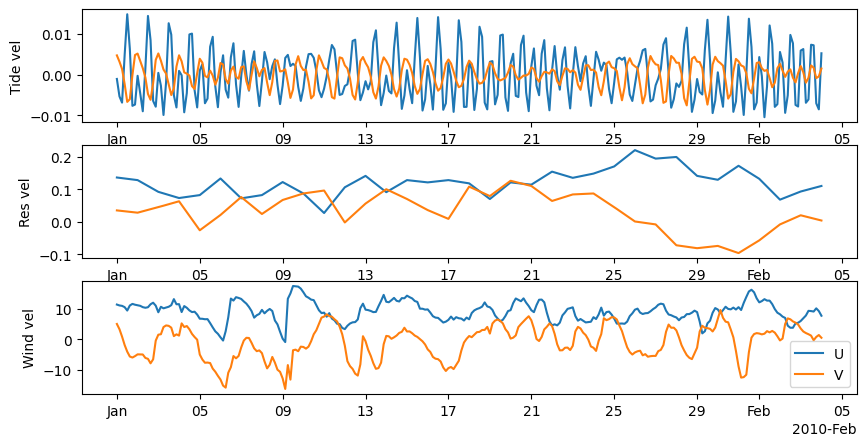

In [ ]:
fig,axs=plt.subplots(3,1)
axs[0].plot(pt['time'],pt['ut'],label='U')
axs[0].plot(pt['time'],pt['vt'],label='V')
axs[0].set_ylabel('Tide vel')
axs[0].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[1].plot(pt['time'],pt['uo'],label='U')
axs[1].plot(pt['time'],pt['vo'],label='V')
axs[1].set_ylabel('Res vel')
axs[1].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[2].plot(pt['time'],pt['ugrd10m'],label='U')
axs[2].plot(pt['time'],pt['vgrd10m'],label='V')
axs[2].set_ylabel('Wind vel')
axs[2].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

plt.legend()
plt.show()

# Clean

In [15]:
os.system('rm current* wind* tide*')

0

In [2]:
all_files=glob.glob('FullData_*')
for file in all_files:
    nc=xr.open_dataset(file)
    nc['uo'][:]+=nc['ut'][:]
    nc['vo'][:]+=nc['ut'][:]
    del nc['ut']
    del nc['vt']
    fileout=file.replace('FullData_','CombineData_')
    nc.to_netcdf(fileout)
    nc.close()
    
    

In [3]:
full_data=xr.open_mfdataset('CombineData_*.nc',concat_dim="time",combine='nested',data_vars ='minimal').drop_duplicates(dim='time')
pt=full_data.isel(longitude=100,latitude=100)

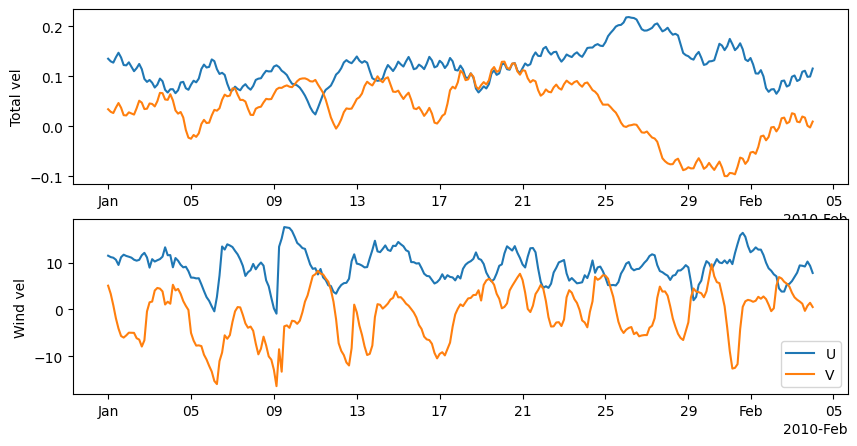

In [6]:
fig,axs=plt.subplots(2,1)
axs[0].plot(pt['time'],pt['uo'],label='U')
axs[0].plot(pt['time'],pt['vo'],label='V')
axs[0].set_ylabel('Total vel')
axs[0].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[1].plot(pt['time'],pt['ugrd10m'],label='U')
axs[1].plot(pt['time'],pt['vgrd10m'],label='V')
axs[1].set_ylabel('Wind vel')
axs[1].xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

plt.legend()
plt.show()